In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels=64):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels=in_channels,
                             out_channels=hidden_channels)
        self.conv2 = GCNConv(in_channels=hidden_channels,
                             out_channels=out_channels)

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [2]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='cora', name='Cora')
data = dataset[0]
print('Cora: ', data)

Cora:  Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


Processing...
Done!


In [3]:
SEED = 42
torch.manual_seed(SEED)
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
    torch.cuda.manual_seed(SEED)

data = data.to(device)
model = GCN(dataset.num_features, dataset.num_classes).to(device)

LR, DECAY = 0.01, 5e-4
loss_fn = F.nll_loss
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR, weight_decay=DECAY)

In [4]:
def train():
    model.train()
    out = model(data.x, data.edge_index)
    loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

In [5]:
def test(mask: torch.Tensor):
    model.eval()
    with torch.inference_mode():
        out = model(data.x, data.edge_index)
        pred_labels = out.argmax(dim=1)[mask]
        true_labels = data.y[mask]
        correct = torch.eq(true_labels, pred_labels).sum().item()
        accuracy = correct / mask.sum().item()
        return accuracy, pred_labels, true_labels

In [6]:
EPOCHS = 200

for epoch in range(1, EPOCHS + 1):
    loss = train()
    if epoch % 10 == 0:
        accuracy, _, _ = test(data.val_mask)
        print(f'Epoch: {epoch} | Train loss: {loss:.4f} | Validation accuracy: {accuracy * 100:.4f}%')

Epoch: 10 | Train loss: 0.1803 | Validation accuracy: 78.4000%
Epoch: 20 | Train loss: 0.0143 | Validation accuracy: 78.0000%
Epoch: 30 | Train loss: 0.0083 | Validation accuracy: 78.8000%
Epoch: 40 | Train loss: 0.0101 | Validation accuracy: 77.2000%
Epoch: 50 | Train loss: 0.0110 | Validation accuracy: 78.6000%
Epoch: 60 | Train loss: 0.0172 | Validation accuracy: 78.2000%
Epoch: 70 | Train loss: 0.0157 | Validation accuracy: 79.0000%
Epoch: 80 | Train loss: 0.0143 | Validation accuracy: 77.6000%
Epoch: 90 | Train loss: 0.0131 | Validation accuracy: 77.6000%
Epoch: 100 | Train loss: 0.0107 | Validation accuracy: 77.4000%
Epoch: 110 | Train loss: 0.0142 | Validation accuracy: 76.0000%
Epoch: 120 | Train loss: 0.0092 | Validation accuracy: 76.0000%
Epoch: 130 | Train loss: 0.0120 | Validation accuracy: 77.0000%
Epoch: 140 | Train loss: 0.0140 | Validation accuracy: 76.8000%
Epoch: 150 | Train loss: 0.0105 | Validation accuracy: 76.6000%
Epoch: 160 | Train loss: 0.0094 | Validation accu

Test accuracy: 81.5000%


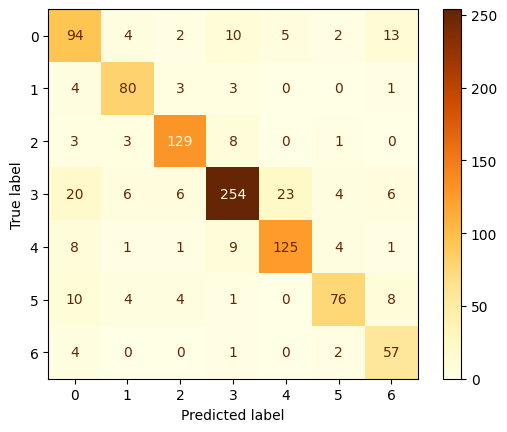

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

test_accuracy, test_pred_labels, test_true_lables = test(data.test_mask)
print(f'Test accuracy: {test_accuracy * 100:.4f}%')

conf_mat = confusion_matrix(test_true_lables, test_pred_labels)
ConfusionMatrixDisplay(conf_mat).plot(cmap='YlOrBr')
plt.show()